In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [2]:
na_values = ['N/A', 'None', 'none', 'NA', 'na', 'NULL', 'null', '-9999', '-9999.0']
df = pd.read_csv('dna_fleet.csv', na_values=na_values)
original_shape = df.shape
df.shape

(4705, 372)

In [3]:
df.head()

,vid,did,pid,class_id,voc_id,type_id,drive_id,fuel_id,day_id,trip_count,...,spd_cat_7_distance,spd_cat_7_mean_speed,spd_cat_7_std_speed,spd_cat_7_ttl,spd_cat_7_zero_speed,spd_cat_8_distance,spd_cat_8_mean_speed,spd_cat_8_std_speed,spd_cat_8_ttl,spd_cat_8_zero_speed
0,236,25,17,7,10,5,0,1,260,4,...,0.0,NaN,NaN,0,0,0.0,NaN,NaN,0,0
1,236,25,17,7,10,5,0,1,262,1,...,0.0,NaN,NaN,0,0,0.0,NaN,NaN,0,0
2,236,25,17,7,10,5,0,1,263,5,...,0.0,NaN,NaN,0,0,0.0,NaN,NaN,0,0
3,236,25,17,7,10,5,0,1,264,3,...,0.0,NaN,NaN,0,0,0.0,NaN,NaN,0,0
4,236,25,17,7,10,5,0,1,265,7,...,0.0,NaN,NaN,0,0,0.0,NaN,NaN,0,0


In [4]:
# Make column names lowercase, replace spaces and special characters with underscores, and ensure uniqueness
def normalize_column(col: str) -> str:
    cleaned = str(col).strip().lower()
    cleaned = cleaned.replace('\n', ' ')
    cleaned = re.sub(r'[%#@]', ' ', cleaned)
    cleaned = re.sub(r'[^0-9a-z]+', '_', cleaned)
    cleaned = re.sub(r'_+', '_', cleaned)
    return cleaned.strip('_')

normalized_columns = [normalize_column(col) for col in df.columns]

# Handle duplicate column names
def make_unique(columns):
    counts = {}
    unique_cols = []
    for col in columns:
        if col in counts:
            counts[col] += 1
            unique_cols.append(f'{col}_{counts[col]}')
        else:
            counts[col] = 0
            unique_cols.append(col)
    return unique_cols

df.columns = make_unique(normalized_columns)

df.head()


,vid,did,pid,class_id,voc_id,type_id,drive_id,fuel_id,day_id,trip_count,...,spd_cat_7_distance,spd_cat_7_mean_speed,spd_cat_7_std_speed,spd_cat_7_ttl,spd_cat_7_zero_speed,spd_cat_8_distance,spd_cat_8_mean_speed,spd_cat_8_std_speed,spd_cat_8_ttl,spd_cat_8_zero_speed
0,236,25,17,7,10,5,0,1,260,4,...,0.0,NaN,NaN,0,0,0.0,NaN,NaN,0,0
1,236,25,17,7,10,5,0,1,262,1,...,0.0,NaN,NaN,0,0,0.0,NaN,NaN,0,0
2,236,25,17,7,10,5,0,1,263,5,...,0.0,NaN,NaN,0,0,0.0,NaN,NaN,0,0
3,236,25,17,7,10,5,0,1,264,3,...,0.0,NaN,NaN,0,0,0.0,NaN,NaN,0,0
4,236,25,17,7,10,5,0,1,265,7,...,0.0,NaN,NaN,0,0,0.0,NaN,NaN,0,0


In [5]:
# Remove columns that are all NaN or constant

all_nan_cols = [col for col in df.columns if df[col].isna().all()]
constant_cols = [col for col in df.columns if df[col].nunique(dropna=True) <= 1]
dropped_cols = sorted(set(all_nan_cols + constant_cols))
if dropped_cols:
    df = df.drop(columns=dropped_cols)

print(f'Original shape: {original_shape}')
print(f'New shape after cleaning: {df.shape}')
print(f'Dropped columns: {len(dropped_cols)}')
if dropped_cols:
    print('Sample dropped columns:', dropped_cols[:10])

Original shape: (4705, 372)
New shape after cleaning: (4705, 338)
Dropped columns: 34
Sample dropped columns: ['average_aerodynamic_power_density_regen', 'average_rolling_power_density_regen', 'cumulative_acceleration_cycle_duration_percent', 'cumulative_acceleration_duration', 'cumulative_deceleration_cycle_duration_percent', 'cumulative_deceleration_duration', 'maximum_rolling_power_density_regen', 'spd_cat_6_distance', 'spd_cat_6_mean_speed', 'spd_cat_6_std_speed']


In [6]:
# Calculate percentage of missing values and format output
missingness = df.isna().mean().sort_values(ascending=False)
missingness.head(20)


non_matched_ttl_std_speed     0.925399
non_matched_ttl_mean_speed    0.925399
func_1_std_speed              0.605101
func_1_mean_speed             0.605101
spd_cat_1_std_speed           0.585547
spd_cat_1_mean_speed          0.585547
spd_cat_2_std_speed           0.537726
spd_cat_2_mean_speed          0.537726
func_2_mean_speed             0.358130
func_2_std_speed              0.358130
spd_cat_3_std_speed           0.126249
spd_cat_3_mean_speed          0.126249
func_3_mean_speed             0.100531
func_3_std_speed              0.100531
spd_cat_5_mean_speed          0.012327
spd_cat_5_std_speed           0.012327
func_4_mean_speed             0.012327
func_4_std_speed              0.012327
spd_cat_4_std_speed           0.010627
spd_cat_4_mean_speed          0.010627
dtype: float64

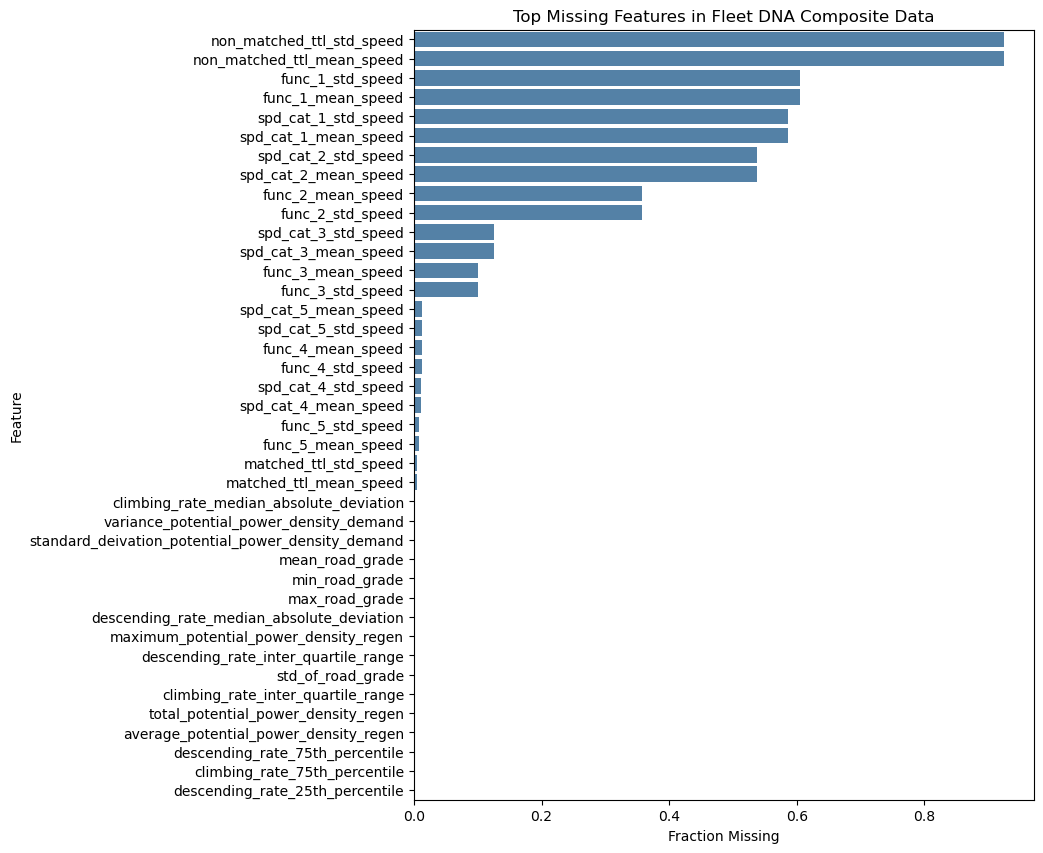

In [7]:
# Checking if missingness is systematic or random
top_missing = missingness.head(40)
plt.figure(figsize=(8,10))
sns.barplot(x=top_missing.values, y=top_missing.index, color="steelblue")
plt.xlabel("Fraction Missing")
plt.ylabel("Feature")
plt.title("Top Missing Features in Fleet DNA Composite Data")
plt.show()

In [8]:
# Drop columns missing more than 80%
cols_drop = missingness[missingness > 0.8].index
df_reduced = df.drop(columns=cols_drop)
print(f"Dropped {len(cols_drop)} columns, kept {df_reduced.shape[1]}")

Dropped 2 columns, kept 336


In [9]:
# Identify highly correlated features
corr = df_reduced.select_dtypes('number').corr().abs()
high_corr = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)) > 0.95)
redundant = [c for c in high_corr.columns if high_corr[c].any()]
print(f"Highly correlated columns (r>0.95): {len(redundant)}")

Highly correlated columns (r>0.95): 129


In [10]:
# Determine columns to drop
to_drop = set()

# Iterate through the correlation matrix
for col in high_corr.columns:
    if col not in to_drop:
        correlated = high_corr.index[high_corr[col]].tolist()
        to_drop.update(correlated)

print(f"Dropping {len(to_drop)} redundant columns")
df_final = df_reduced.drop(columns=list(to_drop))
print(f"Shape after redundancy reduction: {df_final.shape}")

Dropping 127 redundant columns
Shape after redundancy reduction: (4705, 209)


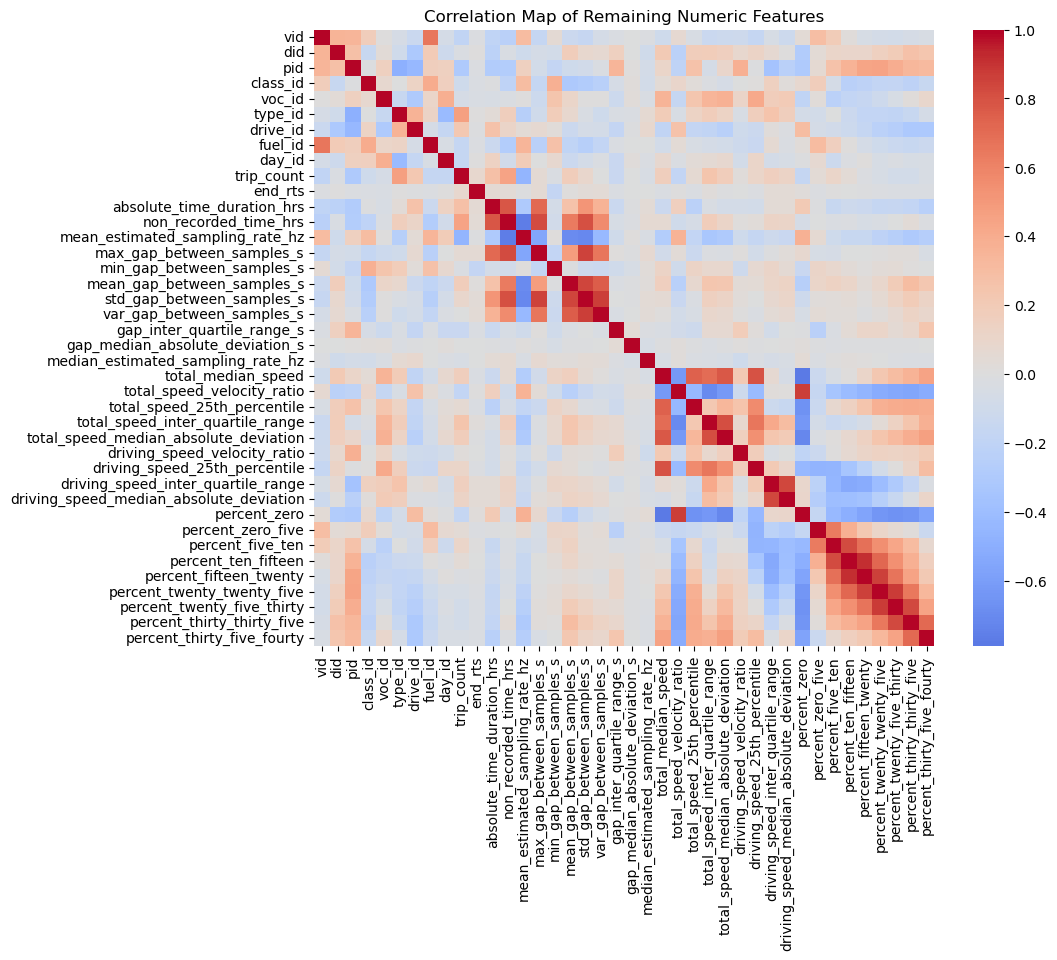

In [11]:
# Visualize correlation map of remaining numeric features
sample_cols = df_final.select_dtypes('number').columns[:40]  # sample 40 for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(df_final[sample_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Map of Remaining Numeric Features")
plt.show()


In [12]:
# Now Checking for missingness patterns again
final_missingness = df_final.isna().mean().sort_values(ascending=False)
final_missingness.head(20)

func_1_mean_speed       0.605101
func_1_std_speed        0.605101
spd_cat_1_mean_speed    0.585547
spd_cat_1_std_speed     0.585547
spd_cat_2_mean_speed    0.537726
spd_cat_2_std_speed     0.537726
func_2_mean_speed       0.358130
func_2_std_speed        0.358130
spd_cat_3_std_speed     0.126249
spd_cat_3_mean_speed    0.126249
func_3_mean_speed       0.100531
func_3_std_speed        0.100531
spd_cat_5_mean_speed    0.012327
func_4_mean_speed       0.012327
spd_cat_5_std_speed     0.012327
func_4_std_speed        0.012327
spd_cat_4_std_speed     0.010627
spd_cat_4_mean_speed    0.010627
func_5_mean_speed       0.007864
func_5_std_speed        0.007864
dtype: float64

## Defining the Target variables

In [13]:
df_final.columns.tolist()

['vid',
 'did',
 'pid',
 'class_id',
 'voc_id',
 'type_id',
 'drive_id',
 'fuel_id',
 'day_id',
 'trip_count',
 'start_ts',
 'end_ts',
 'end_rts',
 'absolute_time_duration_hrs',
 'non_recorded_time_hrs',
 'mean_estimated_sampling_rate_hz',
 'max_gap_between_samples_s',
 'min_gap_between_samples_s',
 'mean_gap_between_samples_s',
 'std_gap_between_samples_s',
 'var_gap_between_samples_s',
 'gap_inter_quartile_range_s',
 'gap_median_absolute_deviation_s',
 'median_estimated_sampling_rate_hz',
 'total_median_speed',
 'total_speed_velocity_ratio',
 'total_speed_25th_percentile',
 'total_speed_inter_quartile_range',
 'total_speed_median_absolute_deviation',
 'driving_speed_velocity_ratio',
 'driving_speed_25th_percentile',
 'driving_speed_inter_quartile_range',
 'driving_speed_median_absolute_deviation',
 'percent_zero',
 'percent_zero_five',
 'percent_five_ten',
 'percent_ten_fifteen',
 'percent_fifteen_twenty',
 'percent_twenty_twenty_five',
 'percent_twenty_five_thirty',
 'percent_thirty

In [14]:
# High idle time ratio flag
# Temporary flag for EDA only
idle_threshold_all = df_final['percent_zero'].quantile(0.8)
df_final['high_idle_flag'] = (df_final['percent_zero'] > idle_threshold_all).astype(int)


In [15]:
# Creating Task specific DataFrames
df_idle     = df_final

## Idle Time Target

In [16]:
df_idle.describe()

,vid,did,pid,class_id,voc_id,type_id,drive_id,fuel_id,day_id,trip_count,...,spd_cat_4_mean_speed,spd_cat_4_std_speed,spd_cat_4_ttl,spd_cat_4_zero_speed,spd_cat_5_distance,spd_cat_5_mean_speed,spd_cat_5_std_speed,spd_cat_5_ttl,spd_cat_5_zero_speed,high_idle_flag
count,4705.000000,4705.000000,4705.000000,4705.000000,4705.000000,4705.000000,4705.000000,4705.000000,4705.000000,4705.000000,...,4655.000000,4655.000000,4705.000000,4705.000000,4705.000000,4647.000000,4647.000000,4705.000000,4705.000000,4705.000000
mean,515.344102,30.866738,12.740701,6.302657,7.013603,27.264825,0.282253,1.048247,21.415303,8.808077,...,14.234734,13.838508,5941.257811,2851.685228,14.789691,8.748916,9.876319,8237.578533,4880.083316,0.200000
std,1649.153738,16.595576,7.139429,1.531626,4.829736,11.130049,0.482510,0.460619,39.004280,5.573292,...,7.053399,3.295493,5626.162074,3931.439033,15.833576,6.583285,3.327976,8179.804062,5754.570777,0.400043
min,1.000000,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,...,0.338548,0.391312,0.000000,0.000000,0.000000,0.167203,0.217689,0.000000,0.000000,0.000000
25%,99.000000,18.000000,6.000000,6.000000,4.000000,26.000000,0.000000,1.000000,4.000000,4.000000,...,8.755555,11.658415,2385.000000,630.000000,4.334191,4.062142,7.674804,2517.000000,748.000000,0.000000
50%,236.000000,33.000000,16.000000,6.000000,5.000000,31.000000,0.000000,1.000000,9.000000,8.000000,...,13.706640,13.916358,4281.000000,1540.000000,9.870664,7.183992,9.766848,5909.000000,2942.000000,0.000000
75%,327.000000,42.000000,18.000000,8.000000,10.000000,36.000000,1.000000,1.000000,16.000000,12.000000,...,19.269429,16.072670,7436.000000,3445.000000,19.641172,11.535937,11.660202,11334.000000,6953.000000,0.000000
max,9868.000000,62.000000,24.000000,8.000000,18.000000,39.000000,3.000000,3.000000,276.000000,40.000000,...,51.943308,26.274381,63762.000000,61256.000000,180.211059,66.642858,25.539499,72975.000000,66435.000000,1.000000


In [17]:
print("High-Idle class balance:")
print(df_idle['high_idle_flag'].value_counts(dropna=False))
print(df_idle['high_idle_flag'].value_counts(normalize=True))

High-Idle class balance:
high_idle_flag
0    3764
1     941
Name: count, dtype: int64
high_idle_flag
0    0.8
1    0.2
Name: proportion, dtype: float64


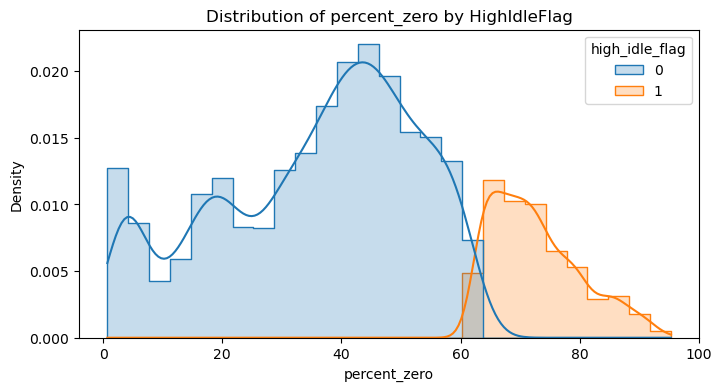

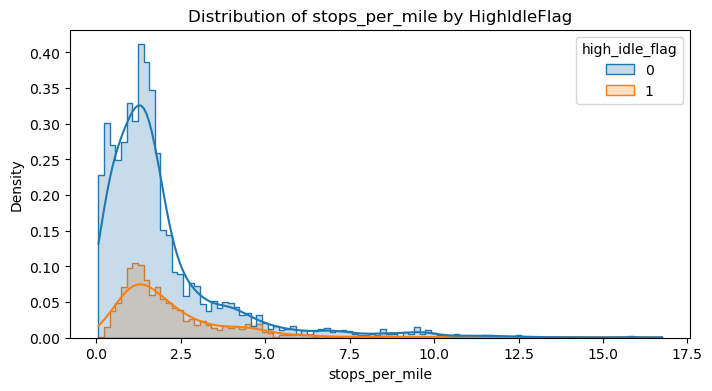

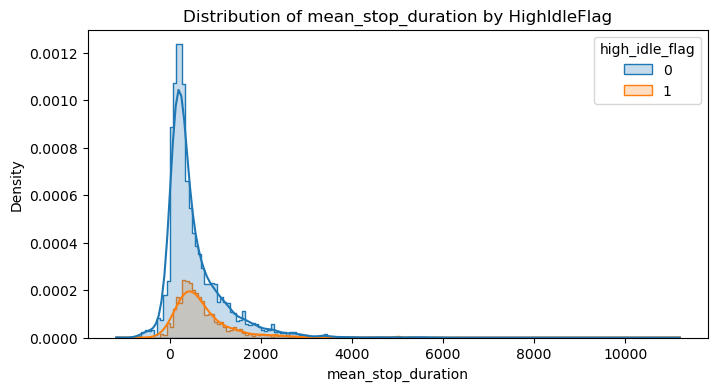

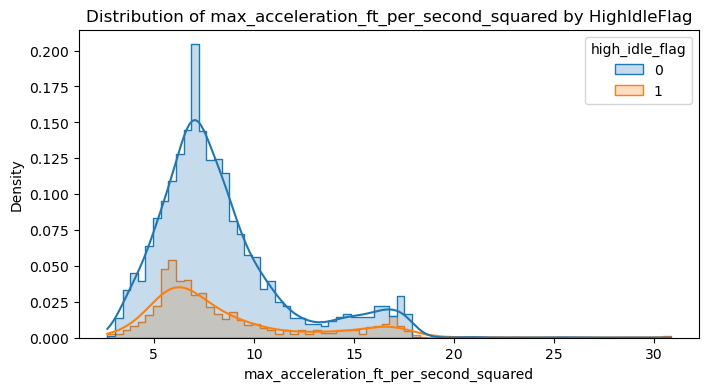

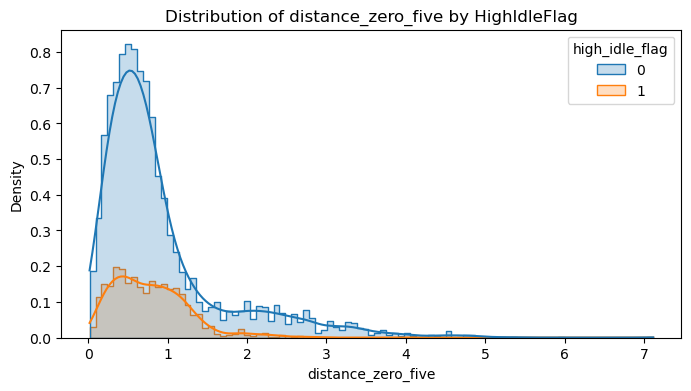

In [18]:
# Visualizations for Idle Time Target
key_feats = ['percent_zero', 'stops_per_mile', 'mean_stop_duration', 
             'max_acceleration_ft_per_second_squared', 'distance_zero_five']

for feat in key_feats:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_idle, x=feat, hue='high_idle_flag', kde=True, element="step", stat="density")
    plt.title(f"Distribution of {feat} by HighIdleFlag")
    plt.show()

- percent_zero vs HighIdleFlag : high-idle trips cluster well above the 80th-percentile cut (~62.5%), with median idle time around 71%, while the low group stays mostly below 60% (median ~39%), so this feature offers clear separation for the classifier.

- stops_per_mile : both classes overlap, but high-idle vehicles skew to more frequent stops (median 1.68 vs 1.41, tail past 10 stops/mile), hinting that repeated stop–go patterns contribute to idling.
- mean_stop_duration : high-idle trips exhibit much longer pauses (median ~9 minutes vs 5 minutes and a heavy upper tail beyond 3 hours), reinforcing that the label captures extended stationary periods.
- max_acceleration_ft_per_second_squared : distributions overlap yet the high-idle class shows a wider spread and higher extreme values (max ~30 ft/s²), suggesting sporadic aggressive launches following long idles; median is slightly lower, so variability, not central tendency, distinguishes the class.
- distance_zero_five : high-idle vehicles cover less distance while creeping at <5 mph (mean ~0.77 vs 0.91 miles) despite similar medians, implying they tend to sit still rather than inch forward, whereas low-idle vehicles accrue more slow-speed movement.

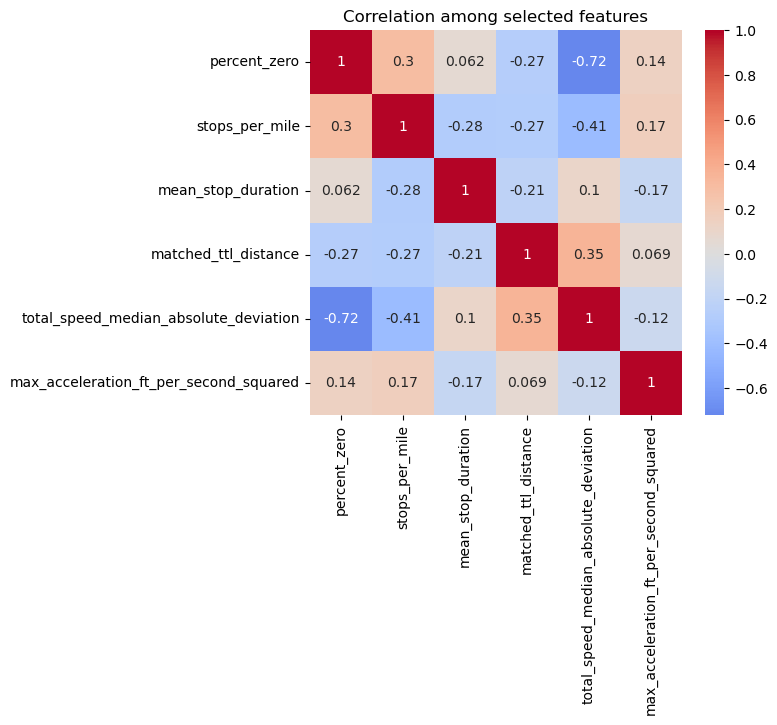

In [19]:
sub_feats = ['percent_zero', 'stops_per_mile', 'mean_stop_duration', 
             'matched_ttl_distance', 'total_speed_median_absolute_deviation', 
             'max_acceleration_ft_per_second_squared']
corr = df_idle[sub_feats].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation among selected features")
plt.show()

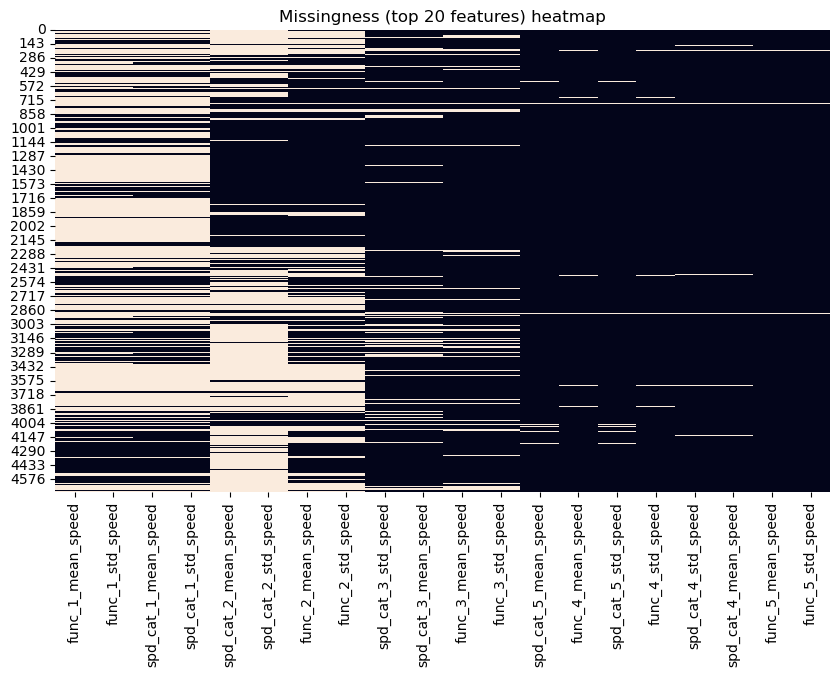

In [20]:
num_feats = df_idle.select_dtypes(include=[np.number]).columns.tolist()
# excluding the target
num_feats = [c for c in num_feats if c != 'high_idle_flag']


# Check missingness patterns again
missing = df_idle[num_feats].isna().mean().sort_values(ascending=False)
top_missing = missing.head(20).index.tolist()
plt.figure(figsize=(10,6))
sns.heatmap(df_idle[top_missing].isna(), cbar=False)
plt.title("Missingness (top 20 features) heatmap")
plt.show()

In [21]:
final_missingness = df_idle.isna().mean().sort_values(ascending=False)
final_missingness.head(20)

func_1_std_speed        0.605101
func_1_mean_speed       0.605101
spd_cat_1_mean_speed    0.585547
spd_cat_1_std_speed     0.585547
spd_cat_2_std_speed     0.537726
spd_cat_2_mean_speed    0.537726
func_2_std_speed        0.358130
func_2_mean_speed       0.358130
spd_cat_3_std_speed     0.126249
spd_cat_3_mean_speed    0.126249
func_3_std_speed        0.100531
func_3_mean_speed       0.100531
spd_cat_5_std_speed     0.012327
func_4_mean_speed       0.012327
func_4_std_speed        0.012327
spd_cat_5_mean_speed    0.012327
spd_cat_4_mean_speed    0.010627
spd_cat_4_std_speed     0.010627
func_5_std_speed        0.007864
func_5_mean_speed       0.007864
dtype: float64

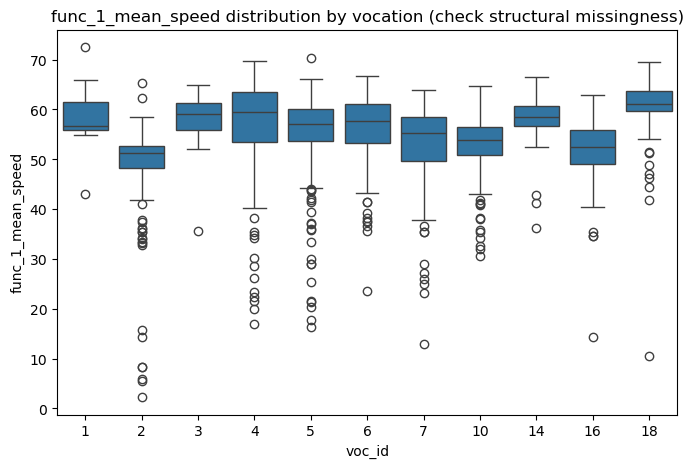

In [22]:
plt.figure(figsize=(8,5))
sns.boxplot(x='voc_id', y='func_1_mean_speed', data=df_idle)
plt.title('func_1_mean_speed distribution by vocation (check structural missingness)')
plt.show()

The missing values are not random — likely structural: some vocations don’t record func_1_* metrics at all.

This is structured missingness, not random noise.
→ Certain vocations (e.g., 2, 10, 14) might not operate under the “func_1” drive-function definition — these fields don’t apply.

Therefore, imputation is acceptable within vocation, but global mean imputation would distort results.

In [23]:
missing_ratio = df_idle.isna().mean()

# --- 2. Compute correlation with target for numeric columns ---
num_cols = df_idle.select_dtypes(include=[np.number]).columns
corr_with_target = df_idle[num_cols].corrwith(df_idle['high_idle_flag']).abs().sort_values(ascending=False)

In [24]:
feature_quality = pd.DataFrame({
    'missing_ratio': missing_ratio,
    'corr_with_target': corr_with_target
}).dropna(subset=['corr_with_target'])

# --- 4. Compute feature quality score ---
feature_quality['quality_score'] = feature_quality['corr_with_target'] / (feature_quality['missing_ratio'] + 0.01)

# --- 5. Inspect top and bottom features ---
print("Top 15 strongest features (high correlation & low missingness):")
print(feature_quality.sort_values(by='quality_score', ascending=False).head(15))

print("\nBottom 15 weakest features:")
print(feature_quality.sort_values(by='quality_score', ascending=True).head(15))

Top 15 strongest features (high correlation & low missingness):
                                       missing_ratio  corr_with_target  \
high_idle_flag                                   0.0          1.000000   
total_speed_velocity_ratio                       0.0          0.745247   
percent_zero                                     0.0          0.695081   
total_speed_inter_quartile_range                 0.0          0.586693   
matched_ttl_zero_speed                           0.0          0.578787   
func_5_zero_speed                                0.0          0.486697   
spd_cat_4_zero_speed                             0.0          0.453081   
total_speed_median_absolute_deviation            0.0          0.445943   
percent_five_ten                                 0.0          0.432806   
percent_ten_fifteen                              0.0          0.426443   
func_4_zero_speed                                0.0          0.414947   
percent_fifteen_twenty                          

In [25]:
# Deciding on a threshold for missingness
# We will drop features with >60% missingness and correlation <0.05
drop_cols = feature_quality[
    (feature_quality['missing_ratio'] > 0.6) &
    (feature_quality['corr_with_target'] < 0.05)
].index.tolist()

print(f"\nDropping {len(drop_cols)} low-value columns:")
print(drop_cols)

df_idle = df_idle.drop(columns=drop_cols)
df_idle.head()


Dropping 1 low-value columns:
['func_1_std_speed']


,vid,did,pid,class_id,voc_id,type_id,drive_id,fuel_id,day_id,trip_count,...,spd_cat_4_mean_speed,spd_cat_4_std_speed,spd_cat_4_ttl,spd_cat_4_zero_speed,spd_cat_5_distance,spd_cat_5_mean_speed,spd_cat_5_std_speed,spd_cat_5_ttl,spd_cat_5_zero_speed,high_idle_flag
0,236,25,17,7,10,5,0,1,260,4,...,18.035824,14.972470,21956,5448,41.059916,4.112503,9.532591,35943,28082,0
1,236,25,17,7,10,5,0,1,262,1,...,7.698682,7.970067,3243,1272,15.357556,7.337386,7.477647,7535,2825,0
2,236,25,17,7,10,5,0,1,263,5,...,3.420157,9.613158,19527,16276,7.773208,3.201413,7.508657,8741,6896,1
3,236,25,17,7,10,5,0,1,264,3,...,12.122880,14.379222,21446,8915,76.678357,7.776052,9.057462,35499,15104,0
4,236,25,17,7,10,5,0,1,265,7,...,9.122673,11.409881,3311,1555,10.048010,2.081291,6.208050,17380,14943,1


In [26]:
# Checking the data types
df_idle.dtypes

vid                       int64
did                       int64
pid                       int64
class_id                  int64
voc_id                    int64
                         ...   
spd_cat_5_mean_speed    float64
spd_cat_5_std_speed     float64
spd_cat_5_ttl             int64
spd_cat_5_zero_speed      int64
high_idle_flag            int64
Length: 209, dtype: object

In [27]:
# Converting datetime columns
df_idle['start_ts'] = pd.to_datetime(df_idle['start_ts'], errors='coerce')
df_idle['end_ts'] = pd.to_datetime(df_idle['end_ts'], errors='coerce')

In [28]:
# Duration of recorded driving for the day (in hours)
df_idle['trip_duration_hours'] = (df_idle['end_ts'] - df_idle['start_ts']).dt.total_seconds() / 3600

# Start time features (time of day)
df_idle['start_hour'] = df_idle['start_ts'].dt.hour
df_idle['start_minute'] = df_idle['start_ts'].dt.minute
df_idle['start_dayofweek'] = df_idle['start_ts'].dt.dayofweek   # Monday=0, Sunday=6

# End time features
df_idle['end_hour'] = df_idle['end_ts'].dt.hour
df_idle['end_dayofweek'] = df_idle['end_ts'].dt.dayofweek

# Dropping the invalidated trip duration rows
df_idle = df_idle[df_idle['trip_duration_hours'] > 0]

# Droppinng the datetime columns after feature extraction
df_idle = df_idle.drop(columns=['start_ts', 'end_ts'])
df_idle.head()

,vid,did,pid,class_id,voc_id,type_id,drive_id,fuel_id,day_id,trip_count,...,spd_cat_5_std_speed,spd_cat_5_ttl,spd_cat_5_zero_speed,high_idle_flag,trip_duration_hours,start_hour,start_minute,start_dayofweek,end_hour,end_dayofweek
0,236,25,17,7,10,5,0,1,260,4,...,9.532591,35943,28082,0,19.937333,3.0,26.0,4.0,23.0,4.0
2,236,25,17,7,10,5,0,1,263,5,...,7.508657,8741,6896,1,18.408667,5.0,28.0,1.0,23.0,1.0
5,236,25,17,7,10,5,0,1,266,3,...,9.112326,27595,13820,0,13.921333,9.0,5.0,4.0,23.0,4.0
6,236,25,17,7,10,5,0,1,268,3,...,8.901353,30929,16548,0,14.052278,9.0,8.0,0.0,23.0,0.0
8,236,25,17,7,10,5,0,1,271,3,...,8.436589,28487,14360,0,13.528833,9.0,1.0,3.0,22.0,3.0


In [29]:
# Imputing the missing values

# For time-related features, we can impute with median values grouped by vocation
for col in ['trip_duration_hours', 'start_hour', 'end_hour']:
    df_idle[col] = df_idle.groupby('voc_id')[col].transform(lambda x: x.fillna(x.median()))

# For other numeric features, we can impute with overall median
numeric_cols = df_idle.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('high_idle_flag')  # exclude target
for col in numeric_cols:
    df_idle[col] = df_idle[col].fillna(df_idle[col].median())
df_idle.head()

,vid,did,pid,class_id,voc_id,type_id,drive_id,fuel_id,day_id,trip_count,...,spd_cat_5_std_speed,spd_cat_5_ttl,spd_cat_5_zero_speed,high_idle_flag,trip_duration_hours,start_hour,start_minute,start_dayofweek,end_hour,end_dayofweek
0,236,25,17,7,10,5,0,1,260,4,...,9.532591,35943,28082,0,19.937333,3.0,26.0,4.0,23.0,4.0
2,236,25,17,7,10,5,0,1,263,5,...,7.508657,8741,6896,1,18.408667,5.0,28.0,1.0,23.0,1.0
5,236,25,17,7,10,5,0,1,266,3,...,9.112326,27595,13820,0,13.921333,9.0,5.0,4.0,23.0,4.0
6,236,25,17,7,10,5,0,1,268,3,...,8.901353,30929,16548,0,14.052278,9.0,8.0,0.0,23.0,0.0
8,236,25,17,7,10,5,0,1,271,3,...,8.436589,28487,14360,0,13.528833,9.0,1.0,3.0,22.0,3.0


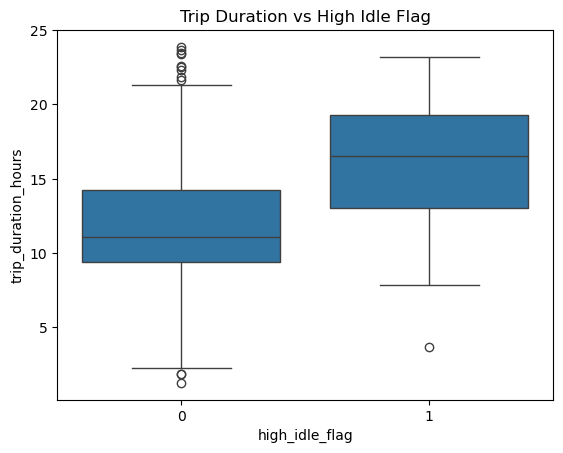

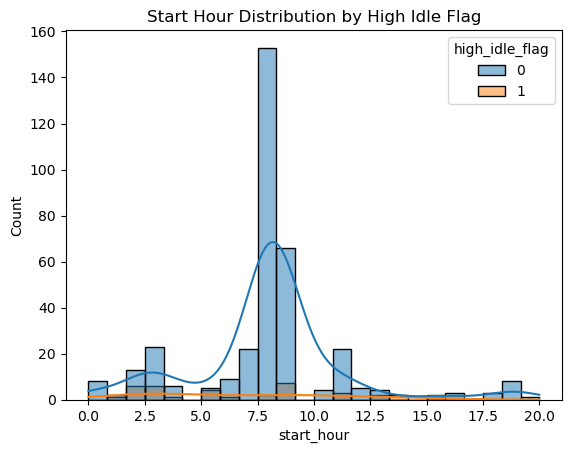

In [30]:
sns.boxplot(x='high_idle_flag', y='trip_duration_hours', data=df_idle)
plt.title("Trip Duration vs High Idle Flag")
plt.show()

sns.histplot(data=df_idle, x='start_hour', hue='high_idle_flag', bins=24, kde=True)
plt.title("Start Hour Distribution by High Idle Flag")
plt.show()

- Median trip duration for high-idle days (class 1) is ~17 hours, compared to ~11 hours for low-idle days (class 0).

- The overall spread is wider for high-idle days; their IQR (inter-quartile range) extends roughly from 13 → 20 hours.

- High-idle records show longer operating days, with multiple outliers near the upper bound (~23–24 hours), implying near-continuous engine logging or extended idling between routes.

In [31]:
X = df_idle.drop(columns=['high_idle_flag'], errors='ignore')
y = df_idle['high_idle_flag']

In [32]:
leakage_keywords = ['zero_speed', 'velocity_ratio', 'matched_ttl', 'func_5']
leak_cols = [c for c in X.columns if any(k in c for k in leakage_keywords)]
print(f"Dropping {len(leak_cols)} potential leakage features:")
print(leak_cols)


Dropping 23 potential leakage features:
['total_speed_velocity_ratio', 'driving_speed_velocity_ratio', 'matched_ttl_distance', 'matched_ttl_mean_speed', 'matched_ttl_std_speed', 'matched_ttl_ttl', 'matched_ttl_zero_speed', 'non_matched_ttl_distance', 'non_matched_ttl_zero_speed', 'func_1_zero_speed', 'func_2_zero_speed', 'func_3_zero_speed', 'func_4_zero_speed', 'func_5_distance', 'func_5_mean_speed', 'func_5_std_speed', 'func_5_ttl', 'func_5_zero_speed', 'spd_cat_1_zero_speed', 'spd_cat_2_zero_speed', 'spd_cat_3_zero_speed', 'spd_cat_4_zero_speed', 'spd_cat_5_zero_speed']


In [33]:
corr_target = X.corrwith(y).abs().sort_values(ascending=False)
print(corr_target.head(15))

total_speed_velocity_ratio                                      0.748847
percent_zero                                                    0.677371
total_speed_inter_quartile_range                                0.550381
spd_cat_5_zero_speed                                            0.480981
func_5_std_speed                                                0.468383
road_grade_median_absolute_deviation                            0.463575
func_5_zero_speed                                               0.453681
matched_ttl_mean_speed                                          0.444606
matched_ttl_zero_speed                                          0.441337
average_absolute_elevation_rate_change                          0.439673
total_speed_median_absolute_deviation                           0.427142
matched_ttl_std_speed                                           0.421115
percent_thirty_five_fourty                                      0.396221
absolute_time_cumulative_deceleration_cycle_duratio

/opt/anaconda3/envs/usml/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/usml/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [34]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X.fillna(0), y)
mi_df = pd.DataFrame({'feature': X.columns, 'mutual_info': mi})
print(mi_df.sort_values(by='mutual_info', ascending=False).head(20))

                                               feature  mutual_info
31                                        percent_zero     0.303073
23                          total_speed_velocity_ratio     0.279217
25                    total_speed_inter_quartile_range     0.271180
118                elevation_median_absolute_deviation     0.221294
120             average_absolute_elevation_rate_change     0.218702
155                             matched_ttl_mean_speed     0.209073
117                     elevation_inter_quartile_range     0.197089
22                                  total_median_speed     0.192707
26               total_speed_median_absolute_deviation     0.184118
131               road_grade_median_absolute_deviation     0.176974
202                               spd_cat_5_mean_speed     0.176204
116                                   var_of_elevation     0.154134
115                                   std_of_elevation     0.152958
130                                  var_of_road

In [36]:
leakage_keywords = ['zero_speed','velocity_ratio','matched_ttl','func_5']
drop_keywords = ['ratio','idle','duration','stop','speed','ttl']
drop_cols = [c for c in X.columns if any(k in c for k in leakage_keywords + drop_keywords)]
X_clean = X.drop(columns=drop_cols, errors='ignore')

In [ ]:

# Combine X_clean and y back into a DataFrame for splitting
df_idle = pd.concat([X_clean, y], axis=1)

df_model = df_idle.drop(columns=['high_idle_flag'], errors='ignore')

train_df, test_df = train_test_split(
    df_model, test_size=0.2, random_state=42, stratify=df_model['voc_id']
)

# Compute threshold only from training subset
idle_threshold_train = train_df['percent_zero'].quantile(0.8)

train_df['high_idle_flag'] = (train_df['percent_zero'] > idle_threshold_train).astype(int)
test_df['high_idle_flag'] = (test_df['percent_zero'] > idle_threshold_train).astype(int)

leakage_keywords = ['zero_speed','velocity_ratio','matched_ttl','func_5']
drop_keywords = ['ratio','percent','zero','idle','duration','stop','speed','ttl']

drop_cols = [c for c in train_df.columns if any(k in c for k in leakage_keywords + drop_keywords)]

X_train = train_df.drop(columns=['high_idle_flag'] + drop_cols, errors='ignore')
y_train = train_df['high_idle_flag']

X_test  = test_df.drop(columns=['high_idle_flag'] + drop_cols, errors='ignore')
y_test  = test_df['high_idle_flag']


In [41]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_weighted = XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)
xgb_weighted.fit(X_train, y_train,
    verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [42]:
y_pred = xgb_weighted.predict(X_test)
y_proba = xgb_weighted.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

precision, recall, _ = precision_recall_curve(y_test, y_proba)
print("PR-AUC:", auc(recall, precision))

              precision    recall  f1-score   support

           0      1.000     0.984     0.992        62
           1      0.944     1.000     0.971        17

    accuracy                          0.987        79
   macro avg      0.972     0.992     0.982        79
weighted avg      0.988     0.987     0.987        79

ROC-AUC: 1.0
PR-AUC: 1.0


In [43]:
y_shuf = shuffle(y_train, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_shuf = cross_val_score(xgb_weighted, X_train, y_shuf, cv=cv, scoring='roc_auc')
print("Mean ROC-AUC (Shuffled Labels):", scores_shuf.mean())

Mean ROC-AUC (Shuffled Labels): 0.45979386626445445
